In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np

In [2]:
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=oxford_iiit_pet:3.1.0
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

I0216 07:17:46.644591 140265141954432 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
oxford_iiit_pet:3.1.0
Traceback (most recent call last):
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow_datasets/scripts/download_and_prepare.py", line 242, in <module>
    app.run(main)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 312, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 258, in _run_main
    sys.exit(main(argv))
  File "/usr/local/lib/python3.7/dist-packages/tensorflow_datasets/scripts/download_and_prepare.py", line 203, in main
    for name in datasets_to_build
  File "/usr/local/lib/python3.7/dist-packages/tensorflow_datasets/scripts/download_and_prepare.py", line 203, in <dictcomp>
    for name i

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteD5QBP2/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteD5QBP2/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [3]:
print(dataset.keys())

dict_keys(['test', 'train'])


In [4]:
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Ja

In [7]:
def random_flip(input_image, input_mask):
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  return input_image, input_mask


def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask


@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
  input_image, input_mask = random_flip(input_image, input_mask)
  input_image, input_mask = normalize(input_image, input_mask)
  
  return input_image, input_mask


def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [8]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [9]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [10]:
class_names = ['pet', 'background', 'outline']



def display(display_list,titles=[], display_string=None):
  plt.figure(figsize=(15, 15))
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
    if display_string and i == 1:
      plt.xlabel(display_string, fontsize=12)
    img_arr = tf.keras.preprocessing.image.array_to_img(display_list[i])
    plt.imshow(img_arr)
  plt.show()


def show_image_from_dataset(dataset):
  for image, mask in dataset.take(1):
    sample_image, sample_mask = image, mask
  display([sample_image, sample_mask], titles=["Image", "True Mask"])


def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(model_history.history[metric_name],color='blue',label=metric_name)
  plt.plot(model_history.history['val_' + metric_name],color='green',label='val_' + metric_name)

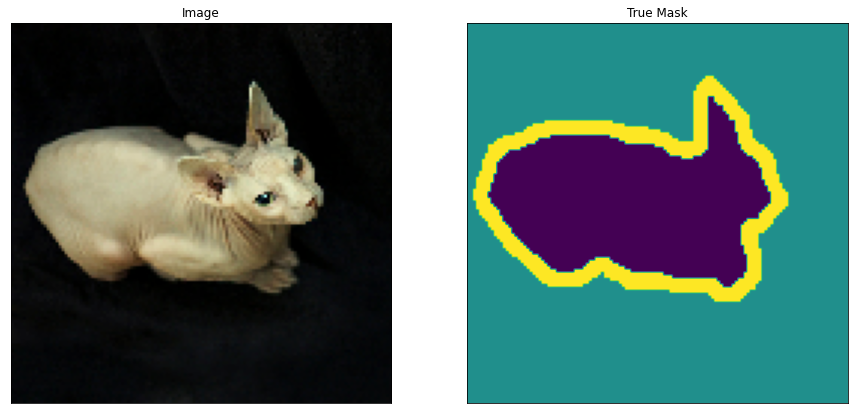

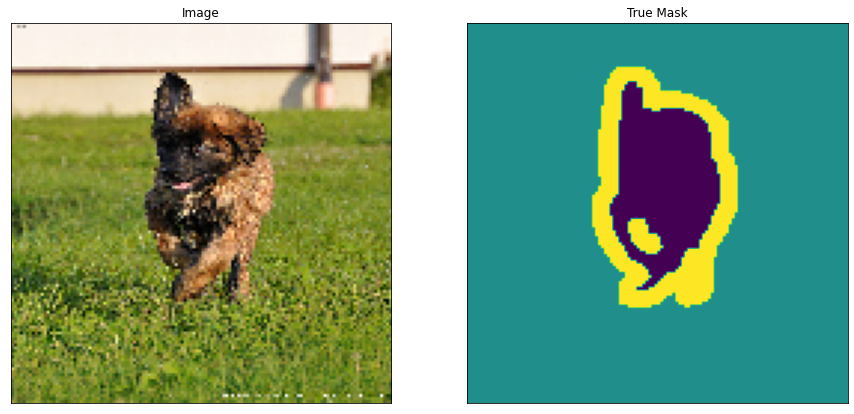

In [11]:
show_image_from_dataset(train)
show_image_from_dataset(test)

In [12]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3):
  x = input_tensor
  for i in range(2):
    x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(x)
    x = tf.keras.layers.Activation('relu')(x)
  
  return x


def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):
  f = conv2d_block(inputs, n_filters=n_filters)
  p = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(f)
  p = tf.keras.layers.Dropout(0.3)(p)

  return f, p


def encoder(inputs):
  f1, p1 = encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
  f2, p2 = encoder_block(p1, n_filters=128, pool_size=(2,2), dropout=0.3)
  f3, p3 = encoder_block(p2, n_filters=256, pool_size=(2,2), dropout=0.3)
  f4, p4 = encoder_block(p3, n_filters=512, pool_size=(2,2), dropout=0.3)

  return p4, (f1, f2, f3, f4)

In [13]:
def bottleneck(inputs):
  bottle_neck = conv2d_block(inputs, n_filters=1024)

  return bottle_neck

In [14]:
def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
  u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides = strides, padding = 'same')(inputs)
  c = tf.keras.layers.concatenate([u, conv_output])
  c = tf.keras.layers.Dropout(dropout)(c)
  c = conv2d_block(c, n_filters, kernel_size=3)

  return c


def decoder(inputs, convs, output_channels):
  f1, f2, f3, f4 = convs

  c6 = decoder_block(inputs, f4, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c7 = decoder_block(c6, f3, n_filters=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c8 = decoder_block(c7, f2, n_filters=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c9 = decoder_block(c8, f1, n_filters=64, kernel_size=(3,3), strides=(2,2), dropout=0.3)

  outputs = tf.keras.layers.Conv2D(output_channels, (1, 1), activation='softmax')(c9)

  return outputs

In [15]:
OUTPUT_CHANNELS = 3

def unet():
  inputs = tf.keras.layers.Input(shape=(128, 128,3,))
  encoder_output, convs = encoder(inputs)

  bottle_neck = bottleneck(encoder_output)

  outputs = decoder(bottle_neck, convs, output_channels=OUTPUT_CHANNELS)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

model = unet()

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 128, 128, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
TRAIN_LENGTH = info.splits['train'].num_examples
EPOCHS = 10
VAL_SUBSPLITS = 5
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset)

Epoch 1/10
57/57 [==============================] - 133s 2s/step - loss: 0.9117 - accuracy: 0.5791 - val_loss: 0.8116 - val_accuracy: 0.6265
Epoch 2/10
57/57 [==============================] - 111s 2s/step - loss: 0.7527 - accuracy: 0.6710 - val_loss: 0.6791 - val_accuracy: 0.7288
Epoch 3/10
57/57 [==============================] - 102s 2s/step - loss: 0.6369 - accuracy: 0.7403 - val_loss: 0.6249 - val_accuracy: 0.7297
Epoch 4/10
57/57 [==============================] - 102s 2s/step - loss: 0.5703 - accuracy: 0.7720 - val_loss: 0.5380 - val_accuracy: 0.7828
Epoch 5/10
57/57 [==============================] - 102s 2s/step - loss: 0.5135 - accuracy: 0.7990 - val_loss: 0.4886 - val_accuracy: 0.8084
Epoch 6/10
57/57 [==============================] - 103s 2s/step - loss: 0.4886 - accuracy: 0.8110 - val_loss: 0.4305 - val_accuracy: 0.8330
Epoch 7/10
57/57 [==============================] - 102s 2s/step - loss: 0.4398 - accuracy: 0.8306 - val_loss: 0.4303 - val_accuracy: 0.8326
Epoch 8/10
57

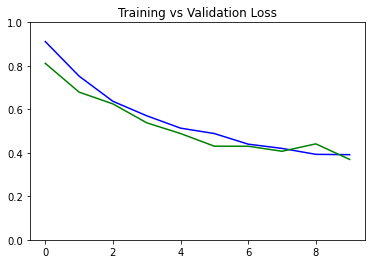

In [18]:
plot_metrics("loss", title="Training vs Validation Loss", ylim=1)

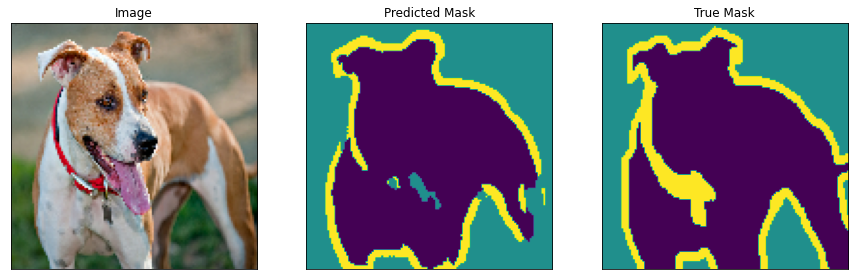

In [19]:
integer_slider = 3646

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0].numpy()


def make_predictions(image, mask, num=1):
  image = np.reshape(image,(1, image.shape[0], image.shape[1], image.shape[2]))
  pred_mask = model.predict(image)
  pred_mask = create_mask(pred_mask)

  return pred_mask

def get_test_image_and_annotation_arrays():
  ds = test_dataset.unbatch()
  ds = ds.batch(info.splits['test'].num_examples)
  
  images = []
  y_true_segments = []

  for image, annotation in ds.take(1):
    y_true_segments = annotation.numpy()
    images = image.numpy()
  
  y_true_segments = y_true_segments[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))]
  
  return images[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))], y_true_segments

y_true_images, y_true_segments = get_test_image_and_annotation_arrays()
y_pred_mask = make_predictions(y_true_images[integer_slider], y_true_segments[integer_slider])


def display(display_list,titles=[], display_string=None):
  plt.figure(figsize=(15, 15))
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
    if display_string and i == 1:
      plt.xlabel(display_string, fontsize=12)
    img_arr = tf.keras.preprocessing.image.array_to_img(display_list[i])
    plt.imshow(img_arr)
  plt.show()

display([y_true_images[integer_slider], y_pred_mask, y_true_segments[integer_slider]], ["Image", "Predicted Mask", "True Mask"])
